# Named Entity Recognition

Named entity recognition, or NER is a Natural Language Processing (NLP) technique that automatically identifies named entities in a text and classifies them into predefined categories. Named 3etities can be names of people, organizations, locations, etc.

In this notebook we will perform this task using a Bi-LSTM neural network

## Importing important libraries



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import TimeDistributed
from tensorflow import keras


## Loading Data

## Data Visualization

In [8]:
data = pd.read_csv('/content/Named-Entity-Recognition-NER/ner_dataset.csv' ,encoding='latin1')
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


As we can see the data uses both POS and IOB tagging

In [9]:
print("TAGS")
print(data['Tag'].value_counts())

TAGS
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64


IOB stands for Inside-Outside-Beginning where:
* `I-` prefix before a tag indicates that the tag is inside a chunk
* `B-` prefix before a tag indicates that the tag is the beginning of a chunk
* `O` tag indicates that a token belongs to no chunk (outside)

The tags following the prefixes show the nature of the chunk itself where:
* `geo` stands for Geographical Entity
* `org` stands for Organization
* per stands for Person
* gpe stands for Geopolitical Entity
* tim stands for Time indicator
* art stands for Artifact
* eve stands for Event
* nat stands for Natural Phenomenon

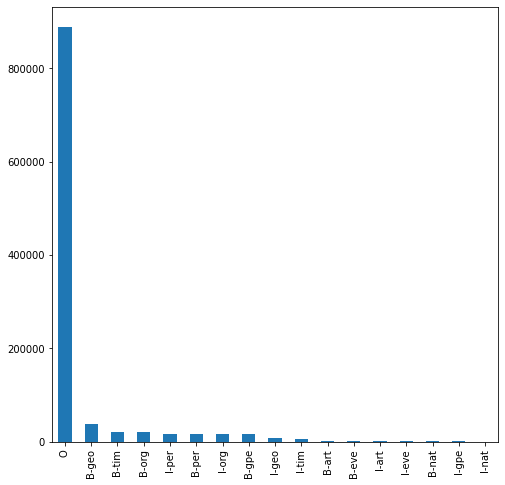

In [10]:
plt.figure(figsize=(8,8))
data['Tag'].value_counts().plot(kind='bar')
plt.show()

## Data Preparation

We make a list of words, tags and sentences


In [11]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [12]:
words = list(set(data['Word'].values))
words.append('ENDPAD')
tags = list(set(data['Tag'].values))
sentences = SentenceGetter(data).sentences
print('Number of sentences:', len(sentences))
print('Number of words:', len(words))
print('Number of tags:', len(tags))

Number of sentences: 47959
Number of words: 35179
Number of tags: 17


## Feature extraction

We transform words, tags and sentences into numbers based on their index. This is also known as label encoding, but because our sentences are a list of lists of tuples we could not use e.g. LabelEncoder.


In [13]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [14]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
print(X[0])
for i in X[0]:
  print(idx2word[i], end = ' ')

[12927, 9783, 20492, 25419, 10502, 29240, 23091, 18597, 12186, 16488, 12261, 27052, 24439, 23611, 27199, 16488, 32690, 9783, 24161, 2433, 34756, 33256, 14449, 29389]
Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . 

In [15]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
print(y[0])
for i in y[0]:
  print(idx2tag[i], end = ' ')

[2, 2, 2, 2, 2, 2, 10, 2, 2, 2, 2, 2, 10, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2]
O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O 

Our sentences and tags need to be the same length

In [16]:
max_len = 50

X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=len(words)-1)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['O'])
print(X[0])
print(y[0])

[12927  9783 20492 25419 10502 29240 23091 18597 12186 16488 12261 27052
 24439 23611 27199 16488 32690  9783 24161  2433 34756 33256 14449 29389
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
[ 2  2  2  2  2  2 10  2  2  2  2  2 10  2  2  2  2  2  7  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2]


In [17]:
y = [to_categorical(i, num_classes=len(tags)) for i in y]

In [18]:
print(y[0])

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.

## Splitting data into train and test set

In [19]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1)
print("Train shapes : X = {}, y = {}".format(train_x.shape, (len(train_y), max_len)))
print("Test shapes : X = {}, y = {}".format(test_x.shape, (len(test_y), max_len)))

Train shapes : X = (43163, 50), y = (43163, 50)
Test shapes : X = (4796, 50), y = (4796, 50)


## Training the model

A Bidirectional LSTM, or Bi-LSTM, is a sequence processing model that consists of two LSTMs: one taking the input in a forward direction and the other in a backwards direction. The inputs are run in two ways: one from past to future (forward) and one from future to past (backward). Differently from a unidirectional LSTM, in the bidirectional the information from both LSTMs are preserved and as a result the model can understand context better.

In [20]:
# create and fit the LSTM network

input = Input(shape=(max_len, ))
model = Embedding(input_dim=len(words), output_dim=50, input_length=max_len)(input)
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(len(tags), activation="softmax"))(model)  # softmax output layer

model = keras.Model(input, out)

opt = keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]) 



In [21]:
history = model.fit(train_x, np.array(train_y), 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
1080/1080 [==============================] - 226s 204ms/step - loss: 0.0784 - accuracy: 0.9782 - val_loss: 0.0478 - val_accuracy: 0.9853
Epoch 2/10
1080/1080 [==============================] - 222s 206ms/step - loss: 0.0347 - accuracy: 0.9889 - val_loss: 0.0469 - val_accuracy: 0.9856
Epoch 3/10
1080/1080 [==============================] - 226s 209ms/step - loss: 0.0273 - accuracy: 0.9910 - val_loss: 0.0493 - val_accuracy: 0.9854
Epoch 4/10
1080/1080 [==============================] - 227s 210ms/step - loss: 0.0234 - accuracy: 0.9922 - val_loss: 0.0531 - val_accuracy: 0.9854
Epoch 5/10
1080/1080 [==============================] - 223s 206ms/step - loss: 0.0211 - accuracy: 0.9928 - val_loss: 0.0549 - val_accuracy: 0.9851
Epoch 6/10
1080/1080 [==============================] - 229s 212ms/step - loss: 0.0191 - accuracy: 0.9934 - val_loss: 0.0580 - val_accuracy: 0.9852
Epoch 7/10
1080/1080 [==============================] - 240s 222ms/step - loss: 0.0179 - accuracy: 0.9939 - val_

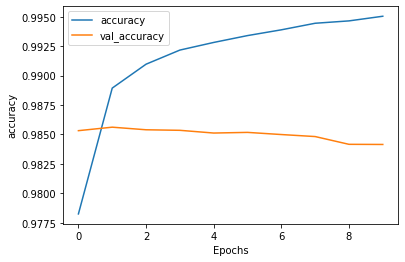

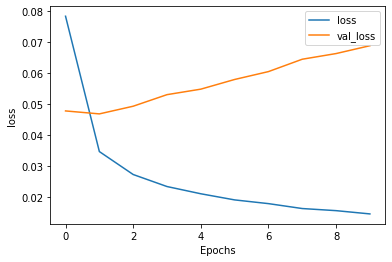

In [22]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [37]:
i = 150
p = model.predict(np.array([test_x[i]]))
p = np.argmax(p, axis=-1)

print("{:15} {:15} {}".format("Word", "Predicted tag", "True tag"))
for w, pred, true in zip(test_x[i], p[0], test_y[i]):
  if idx2word[w] != "ENDPAD":
    true_tag = list(true).index(1.0)
    print("{:15}:{:15} ({})".format(idx2word[w], tags[pred], tags[true_tag]))

Word            Predicted tag   True tag
World          :O               (O)
leaders        :O               (O)
have           :O               (O)
been           :O               (O)
pressing       :O               (O)
Sudan          :B-org           (B-gpe)
to             :O               (O)
accept         :O               (O)
a              :O               (O)
U.N.           :B-geo           (B-org)
peacekeeping   :O               (O)
force          :O               (O)
in             :O               (O)
Darfur         :B-geo           (B-geo)
.              :O               (O)


In [24]:
total = 0
count = 1

for i in range(4796): #axis 0 size
  p = model.predict(np.array([test_x[i]]))
  p = np.argmax(p, axis=-1)
  for w, pred, true in zip(test_x[i], p[0], test_y[i]):
    total += 1
    if idx2word[w] != "ENDPAD":
      true_tag = list(true).index(1.0)
      if tags[pred] == tags[true_tag]:
        count += 1

print('Accuracy:', round((count/total)*100, 2))

Accuracy: 42.21
